# EE P 590: Deep Learning for Embedded Real-time Intelligence 

# Kevin Egedy

# Homework 3  

In [1]:
import torch 
from eep590_utils import * 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 0. Warm-up (40 points) 

###  Answer the following in your own words (read and understand the concepts, do not copy answers from the internet): 

**(a.) Explain why the depth-wise separable convolutions can achieve reasonable results while using fewer parameters compared to traditional convolutions. Also compare the representation power of a depth-wise separable convolution to that of a standard convolution if both had the same number of parameters.**

#TODO: DONE \
Ref: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

Depth-wise separable achieves the same transformation by taking the convolution over slices of the data and then performing a point-wise convolution. The end result is similar but uses far fewer parameters due to serparating the convolution into two steps. Depth-wise separable convolutions have huge savings on the number of computations (>10x savings) because the computations during the depth-wise convolution are much smaller than the computations in normal convolution.

**(b.) Comment on the quantization bit-widths (for a deep learning model) required to achieve good performance for speech/audio inputs and compare it to that for image inputs. Which type of input requires higher number of bits to achieve reasonable performance, and why?** 

#TODO: DONE \
Ref: https://www.qualcomm.com/news/onq/2019/03/heres-why-quantization-matters-ai \
Ref: https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/KoFrommPhiliposeTashevZarar_NIPS2017.pdf \
Ref: https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505


Relatively good performance is achieved with as low as 8 bits (and lower) for image inputs and 4 bits for audio inputs. In general, image inputs require larger number of bits compared to speech/audio. The extracted features/targets for image datasets require more information (larger bit-widths) than speech/audio. In addition, human comprehension of different frequencies is very limitied.

**(c.) From an optimization perspective, why is it challenging to train a deep learning model with quantized weights and activations?** 

#TODO: DONE 

Ref: https://proceedings.neurips.cc/paper/2017/file/1c303b0eed3133200cf715285011b4e4-Paper.pdf

Quantized weights and activations make it difficult for models to converge due to limiting training improvement. 

**(d.) What is the impact of low-rank projections on the generalization ability of a deep learning model? Explain your reasoning.**

#TODO: DONE

Low-rank projections prunes the weights of the models so that it doesn't overfit to the dataset. Also it can dramatically reduce the number of weights/connections (>80% reduction).

**(e.) What is the motive to deploy deep learning models on embedded/IoT devices? List the problems associated with sending the data from the IoT device to the cloud through wifi and performing the inference on the cloud**

#TODO: DONE \
Ref: https://www.wevolver.com/article/the-embedded-machine-learning-revolution-the-basics-you-need-to-know

Primary reasons for deploying models to embedded devices are lower power consumption, low latency, network efficiency, and strong privacy. Sending data to the cloud is very costly even with quantized inputs. Depending on the application, the latency of cloud solutions is too large to use in real-time.  

**(f.) In one or more sentences, and using sketches as appropriate, explain: SqueezeNet and MobileNet. What are the defining characteristic of these architectures? How do they improve upon their predecessors in terms of latency and memory consumption?**

<img src="img/SqueezeNet.png" width="300"/>

<img src="img/MobileNet.png" width="300"/>

#TODO: DONE \
Ref: https://aiinpractice.com/squeezenet-mobilenet/

SqueezeNet achieves the same accuracy as AlexNet but has 50x less weights. SqueezeNet is implemented by replacing 3x3 filters with 1x1 filters, decreasing the number of input channels to 3x3 filters, and downsampling late in the network so that convolution layers have large activation maps.

MobileNet can outperform SqueezeNet in most cases by having a comparable model size. MobileNet is implemented using depthwise separable convolutions with pointwise convolution and can greatly improve prediction speed by reducing the image size.

**(f.) Compare and contrast the different pruning techniques discussed in the lecture. Which technique would produce the  most optimal results? Which technique is the most practical? Explain your reasoning.**

#TODO: DONE

Iterative pruning & retraining, pruning with rehabilitation, and hessian-based pruning are the techniques discussed in lecture.

Iterative pruning and retraining is effective but takes multiple iterations since pruned connections have no chance to come back in this method. 

Hessian pruning provides the most optimal results. The weights are updated in order to minimize the change of the objective function, however it requires a lot more computations. 

Pruning with rehabilitation is updated based on the pruning threshold and is the most practical.

**(g.) Explain how Scree plots are useful in resource allocation and determining each layer's target rank.**

#TODO: DONE \
Ref: https://en.wikipedia.org/wiki/Scree_plot

A scree plot plots the eigenvalues / principal components which are used for understanding the variability of the dataset. A layer's target rank is determined by the elbow of the graph, such that all the proceeding eigenvalues are significant.

**(h.) Compare and contrast the different quantization techniques discussed in the lectures, and comment on the strengths and limitations of each technique.**

#TODO: DONE \
Ref: https://medium.com/@joel_34050/quantization-in-deep-learning-478417eab72b

Full quantization fixed point, full quantization code book, quantization binary connect, and quantization binarized neural networks are the techniques discussed in lecture.

Binary connect maps float-valued parameters to +1 or -1. This method is ideal for it's simplistic implementation.

BNN achieves higher accuracy than binary connect. It quantizes the activations to binary values -1 and +1 by taking the sign of the full-precision activations.

# 1. Low-rank approximation (30 points) 

In this section we will use low-rank approximations of the dense layers to reduce the memory consumption of a simple  LeNet architecture during inference. To make it simpler, we have divided this into subtasks:- 

- **(8 points) Subtask 1: Train a standard LeNet architercture on the Fashion MNIST dataset. Use the `load_data_fashion_mnist` function provided in the `eep590_utils.py` file for downloading and loading the dataset. The model architecture is defined below for your convenience, but you are free to use any other implementations of the same architecture. Use a set of reasonable hyper-parameters to obtain an accuracy of atleast 75 percentage on the training and testing sets.** 

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
#TODO: DONE

# def load_data_fashion_mnist(batch_size, resize=None):
#     """Download the Fashion-MNIST dataset and then load it into memory."""

import torch.optim as optim

params = {
  "learning_rate": 1e-2,
  "batch_size": 64,
  "num_epochs": 4
}

# Get Fashion MNIST datasets
train, test = load_data_fashion_mnist(params['batch_size'])

# Define Model
model = LeNet()

# Define Optimizer
optimizer = optim.Adam(
    model.parameters(), 
    lr=params['learning_rate']
)

# Define Loss Function
loss_fn = nn.CrossEntropyLoss()

# Train dataset
def train_model(model, optimizer, loss_fn, params):
    '''
    Trains model with given optimizer and loss function.
    Returns accuracy in each epoch
    '''
    for epoch in range(params['num_epochs']):
        num_labels = 0
        num_correct = 0

        # Features and Labels
        for X, y in train:

            # Reset gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X)

            # Loss
            loss = loss_fn(outputs, y)

            # Backward pass
            loss.backward()

            # Update Optimizer
            optimizer.step()

            # Calculate Accuracy
            outputs = outputs.detach().numpy()
            outputs = np.argmax(outputs, axis=1)
            y = y.detach().numpy()
            num_correct += np.sum(outputs == y)
            num_labels += y.shape[0]

        # Print
        acc = num_correct / num_labels
        print(f'Epoch {epoch}:   Accuracy: {round(100*num_correct/num_labels,2)}%')

In [5]:
train_model(model, optimizer, loss_fn, params)

Epoch 0:   Accuracy: 79.77%
Epoch 1:   Accuracy: 85.75%
Epoch 2:   Accuracy: 86.77%
Epoch 3:   Accuracy: 87.46%


- **(10 points) Subtask 2: Project the `self.fc1` and `self.fc2` weights to subspaces with ranks `r1` and `r2`.** 

In [6]:
# Save Model Weights
fc1_SAVE = model.fc1.weight.detach()
fc2_SAVE = model.fc2.weight.detach()

In [24]:
#TODO: DONE
# https://pytorch.org/docs/stable/generated/torch.linalg.svd.html

def Weight2Subspace(weight, rank):
    # Find SVD Representation
    U, S, VT = torch.linalg.svd(weight)
 
    # New Subspace (with reduced weights)
    F1 = U[:, :rank] @ torch.diag(S[:rank])
    F2 = torch.diag(S[:rank]) @ VT[:rank, :]
    
    # Recombined
    W = torch.matmul(F1,F2)
    
    return W, F1, F2

W1, F11, F12 = Weight2Subspace(fc1_SAVE, 20)
W2, F21, F22 = Weight2Subspace(fc2_SAVE, 20)
prev = fc1_SAVE.shape[0]*fc1_SAVE.shape[1]
new = F11.shape[0]*F11.shape[1] + F12.shape[0]*F12.shape[1]
print(f'Original fc1 size: {prev} doubles')
print(f'New fc1 size: {new} doubles')
print(f'Improvement: {round(prev/new,2)}')

Original fc1 size: 48000 doubles
New fc1 size: 10400 doubles
Improvement: 4.62


- **(4 points) Plot a graph with the X-axis representing the %improvement in memory usage of the architure, and on Y-axis the test accuracy of the model. (Hint: play with `r1` and `r2`, and run the inference multiple times. You need not re-train the model)** 

In [8]:
model.fc1.weight.data = fc1_SAVE
model.fc2.weight.data = fc2_SAVE

r1 = 10, r2 = 10, impr = 8.02, acc = 0.7
r1 = 10, r2 = 20, impr = 6.26, acc = 0.77
r1 = 10, r2 = 30, impr = 5.13, acc = 0.77
r1 = 10, r2 = 40, impr = 4.35, acc = 0.77
r1 = 10, r2 = 50, impr = 3.77, acc = 0.77
r1 = 20, r2 = 10, impr = 4.67, acc = 0.72
r1 = 20, r2 = 20, impr = 4.01, acc = 0.79
r1 = 20, r2 = 30, impr = 3.52, acc = 0.79
r1 = 20, r2 = 40, impr = 3.13, acc = 0.79
r1 = 20, r2 = 50, impr = 2.82, acc = 0.79
r1 = 30, r2 = 10, impr = 3.29, acc = 0.72
r1 = 30, r2 = 20, impr = 2.95, acc = 0.79
r1 = 30, r2 = 30, impr = 2.67, acc = 0.8
r1 = 30, r2 = 40, impr = 2.44, acc = 0.8
r1 = 30, r2 = 50, impr = 2.25, acc = 0.8
r1 = 40, r2 = 10, impr = 2.54, acc = 0.72
r1 = 40, r2 = 20, impr = 2.33, acc = 0.79
r1 = 40, r2 = 30, impr = 2.16, acc = 0.8
r1 = 40, r2 = 40, impr = 2.01, acc = 0.8
r1 = 40, r2 = 50, impr = 1.87, acc = 0.8
r1 = 50, r2 = 10, impr = 2.07, acc = 0.72
r1 = 50, r2 = 20, impr = 1.93, acc = 0.79
r1 = 50, r2 = 30, impr = 1.81, acc = 0.8
r1 = 50, r2 = 40, impr = 1.7, acc = 0.8
r1

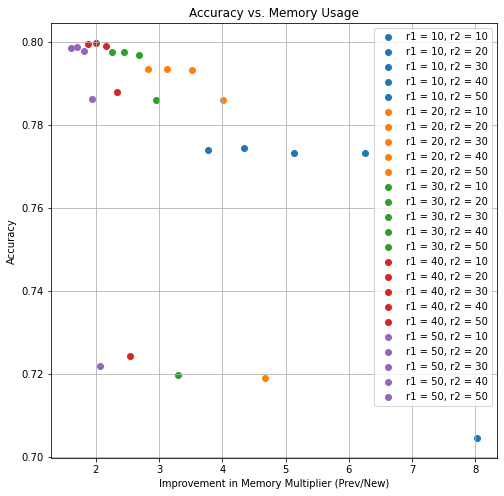

In [9]:
#TODO: DONE
fig, ax = plt.subplots(1,figsize=(8,8))

# Original Weight Size 
ws1 = fc1_SAVE.shape[0]*fc1_SAVE.shape[1]
ws2 = fc2_SAVE.shape[0]*fc2_SAVE.shape[1]
weights = ws1 + ws2

# Define Ranks
r1_arr = [10,20,30,40,50]
r2_arr = [10,20,30,40,50]

# Colors
colors = [
'tab:blue',
'tab:orange',
'tab:green',
'tab:red',
'tab:purple'
]

for i, r1 in enumerate(r1_arr):
    for r2 in r2_arr:
        num_labels = 0
        num_correct = 0
        acc = 0

        # Calculate Improvement
        W1, F11, F12 = Weight2Subspace(fc1_SAVE,r1)
        W2, F21, F22 = Weight2Subspace(fc2_SAVE,r2)
        new_ws1 = F11.shape[0]*F11.shape[1] + F12.shape[0]*F12.shape[1]
        new_ws2 = F21.shape[0]*F21.shape[1] + F22.shape[0]*F22.shape[1]
        new_weights = new_ws1 + new_ws2
        improvement = weights/new_weights

        # assign new weights
        model.fc1.weight.data = W1.data
        model.fc2.weight.data = W2.data

        for X, y in train:
            # Calculate Accuracy
            outputs = model(X)
            outputs = outputs.detach().numpy()
            outputs = np.argmax(outputs, axis=1)
            y = y.detach().numpy()
            num_correct += np.sum(outputs == y)
            num_labels += y.shape[0]

        acc = num_correct / num_labels
        print(f'r1 = {r1}, r2 = {r2}, impr = {round(improvement,2)}, acc = {round(acc,2)}')
        ax.scatter(improvement, acc, color=colors[i], label=f'r1 = {r1}, r2 = {r2}')

ax.set_title('Accuracy vs. Memory Usage')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Improvement in Memory Multiplier (Prev/New)')
ax.grid(True)
ax.legend()
plt.show();

- **(4 points) Plot a graph of the %improvement in memory usage vs. $\beta$, which is the percentage of total variation explained in the low-rank subspace. (Hint: Refer to slide 42 of the lecture)**

r1 = 10, r2 = 10, impr = 8.02, beta = 0.34
r1 = 10, r2 = 20, impr = 6.26, beta = 0.39
r1 = 10, r2 = 30, impr = 5.13, beta = 0.42
r1 = 10, r2 = 40, impr = 4.35, beta = 0.45
r1 = 10, r2 = 50, impr = 3.77, beta = 0.46
r1 = 20, r2 = 10, impr = 4.67, beta = 0.48
r1 = 20, r2 = 20, impr = 4.01, beta = 0.53
r1 = 20, r2 = 30, impr = 3.52, beta = 0.56
r1 = 20, r2 = 40, impr = 3.13, beta = 0.58
r1 = 20, r2 = 50, impr = 2.82, beta = 0.6
r1 = 30, r2 = 10, impr = 3.29, beta = 0.58
r1 = 30, r2 = 20, impr = 2.95, beta = 0.63
r1 = 30, r2 = 30, impr = 2.67, beta = 0.66
r1 = 30, r2 = 40, impr = 2.44, beta = 0.69
r1 = 30, r2 = 50, impr = 2.25, beta = 0.7
r1 = 40, r2 = 10, impr = 2.54, beta = 0.66
r1 = 40, r2 = 20, impr = 2.33, beta = 0.71
r1 = 40, r2 = 30, impr = 2.16, beta = 0.74
r1 = 40, r2 = 40, impr = 2.01, beta = 0.77
r1 = 40, r2 = 50, impr = 1.87, beta = 0.78
r1 = 50, r2 = 10, impr = 2.07, beta = 0.73
r1 = 50, r2 = 20, impr = 1.93, beta = 0.78
r1 = 50, r2 = 30, impr = 1.81, beta = 0.81
r1 = 50, r2 =

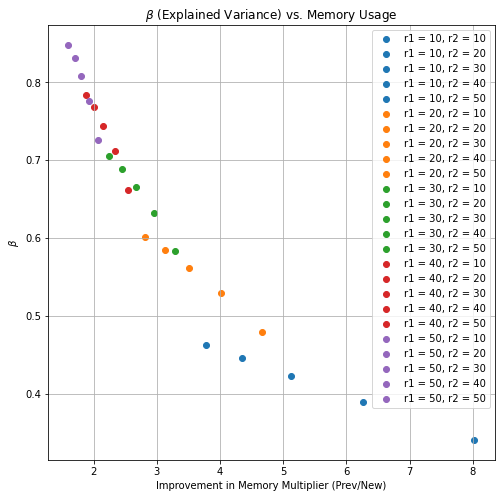

In [10]:
#TODO: DONE
fig, ax = plt.subplots(1,figsize=(8,8))

# Define Ranks
r1_arr = [10,20,30,40,50]
r2_arr = [10,20,30,40,50]

# Original Weight Size 
ws1 = fc1_SAVE.shape[0]*fc1_SAVE.shape[1]
ws2 = fc2_SAVE.shape[0]*fc2_SAVE.shape[1]
weights = ws1 + ws2

# Compute Singular Values
_, S1, _ = torch.linalg.svd(fc1_SAVE)
_, S2, _ = torch.linalg.svd(fc2_SAVE)
vals1, _ = torch.max(torch.diag(S1), dim=1)
vals2, _ = torch.max(torch.diag(S2), dim=1)

# Colors
colors = [
'tab:blue',
'tab:orange',
'tab:green',
'tab:red',
'tab:purple'
]

for i, r1 in enumerate(r1_arr):
    for r2 in r2_arr:
        num_labels = 0
        num_correct = 0
        acc = 0

        # Calculate Improvement
        W1, F11, F12 = Weight2Subspace(fc1_SAVE,r1)
        W2, F21, F22 = Weight2Subspace(fc2_SAVE,r2)
        new_ws1 = F11.shape[0]*F11.shape[1] + F12.shape[0]*F12.shape[1]
        new_ws2 = F21.shape[0]*F21.shape[1] + F22.shape[0]*F22.shape[1]
        new_weights = new_ws1 + new_ws2
        improvement = weights/new_weights     
            
        # Calculate Beta
        num = torch.sum(vals1[:r1])+torch.sum(vals2[:r2])
        den = torch.sum(vals1)+torch.sum(vals2)
        beta = torch.div(num,den)
        beta = beta.detach().numpy().item(0)
        
        # Plot
        print(f'r1 = {r1}, r2 = {r2}, impr = {round(improvement,2)}, beta = {round(beta,2)}')
        ax.scatter(improvement, beta, color=colors[i], label=f'r1 = {r1}, r2 = {r2}')

ax.set_title(r'$\beta$ (Explained Variance) vs. Memory Usage')
ax.set_ylabel(r'$\beta$')
ax.set_xlabel('Improvement in Memory Multiplier (Prev/New)')
ax.grid(True)
ax.legend()
plt.show();

- **(4 points) Plot a graph of test accuracy vs. $\beta$.** 

r1 = 10, r2 = 10, beta = 0.34, acc = 0.7
r1 = 10, r2 = 20, beta = 0.39, acc = 0.77
r1 = 10, r2 = 30, beta = 0.42, acc = 0.77
r1 = 10, r2 = 40, beta = 0.45, acc = 0.77
r1 = 10, r2 = 50, beta = 0.46, acc = 0.77
r1 = 20, r2 = 10, beta = 0.48, acc = 0.72
r1 = 20, r2 = 20, beta = 0.53, acc = 0.79
r1 = 20, r2 = 30, beta = 0.56, acc = 0.79
r1 = 20, r2 = 40, beta = 0.58, acc = 0.79
r1 = 20, r2 = 50, beta = 0.6, acc = 0.79
r1 = 30, r2 = 10, beta = 0.58, acc = 0.72
r1 = 30, r2 = 20, beta = 0.63, acc = 0.79
r1 = 30, r2 = 30, beta = 0.66, acc = 0.8
r1 = 30, r2 = 40, beta = 0.69, acc = 0.8
r1 = 30, r2 = 50, beta = 0.7, acc = 0.8
r1 = 40, r2 = 10, beta = 0.66, acc = 0.72
r1 = 40, r2 = 20, beta = 0.71, acc = 0.79
r1 = 40, r2 = 30, beta = 0.74, acc = 0.8
r1 = 40, r2 = 40, beta = 0.77, acc = 0.8
r1 = 40, r2 = 50, beta = 0.78, acc = 0.8
r1 = 50, r2 = 10, beta = 0.73, acc = 0.72
r1 = 50, r2 = 20, beta = 0.78, acc = 0.79
r1 = 50, r2 = 30, beta = 0.81, acc = 0.8
r1 = 50, r2 = 40, beta = 0.83, acc = 0.8
r1 

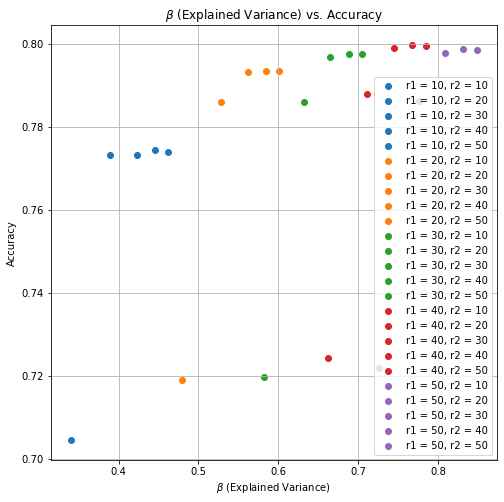

In [11]:
#TODO: DONE
fig, ax = plt.subplots(1,figsize=(8,8))

# Define Ranks
r1_arr = [10,20,30,40,50]
r2_arr = [10,20,30,40,50]

# Compute Singular Values
_, S1, _ = torch.linalg.svd(fc1_SAVE)
_, S2, _ = torch.linalg.svd(fc2_SAVE)
vals1, _ = torch.max(torch.diag(S1), dim=1)
vals2, _ = torch.max(torch.diag(S2), dim=1)

# Colors
colors = [
'tab:blue',
'tab:orange',
'tab:green',
'tab:red',
'tab:purple'
]

for i, r1 in enumerate(r1_arr):
    for r2 in r2_arr:
        num_labels = 0
        num_correct = 0
        acc = 0

        # Define Subspace
        W1, F11, F12 = Weight2Subspace(fc1_SAVE,r1)
        W2, F21, F22 = Weight2Subspace(fc2_SAVE,r2)

        # assign new weights
        model.fc1.weight.data = W1.data
        model.fc2.weight.data = W2.data

        for X, y in train:
            # Calculate Accuracy
            outputs = model(X)
            outputs = outputs.detach().numpy()
            outputs = np.argmax(outputs, axis=1)
            y = y.detach().numpy()
            num_correct += np.sum(outputs == y)
            num_labels += y.shape[0]
            
        # Calculate Beta
        num = torch.sum(vals1[:r1])+torch.sum(vals2[:r2])
        den = torch.sum(vals1)+torch.sum(vals2)
        beta = torch.div(num,den)
        beta = beta.detach().numpy().item(0)

        acc = num_correct / num_labels
        print(f'r1 = {r1}, r2 = {r2}, beta = {round(beta,2)}, acc = {round(acc,2)}')
        ax.scatter(beta, acc, color=colors[i], label=f'r1 = {r1}, r2 = {r2}')

ax.set_title(r'$\beta$ (Explained Variance) vs. Accuracy')
ax.set_xlabel(r'$\beta$ (Explained Variance)')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()
plt.show();

# 2. Sparsification (30 points) 

In this section we will attempt to sparsify the model trained in subtask 1 of previous section. 

- **Subtask 1: Plot a histogram of the distribution of all the weights in the model.** 

In [12]:
model.fc1.weight.data = fc1_SAVE
model.fc2.weight.data = fc2_SAVE

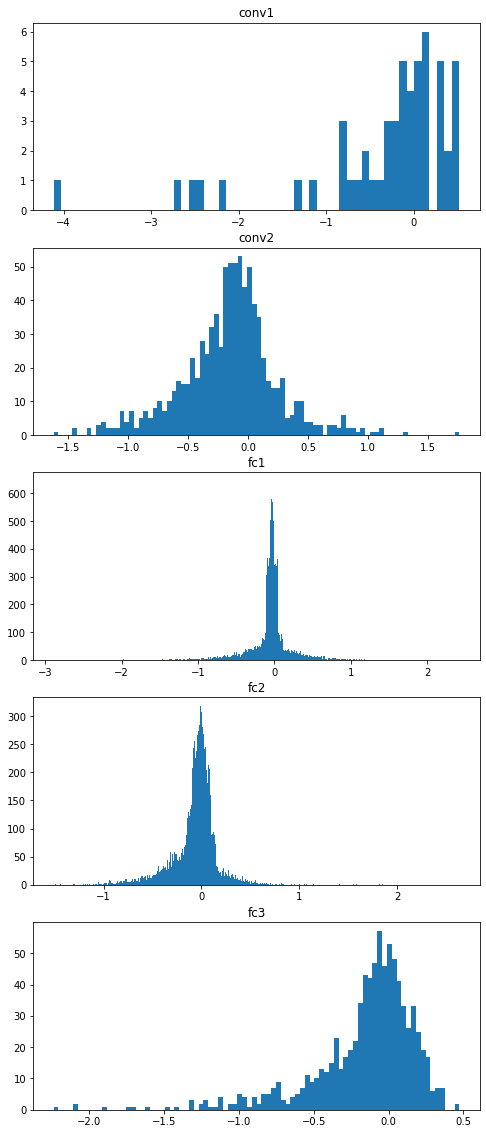

In [13]:
#TODO: DONE
fig, ax = plt.subplots(5,1,figsize=(8,20))

conv1 = model.conv1.weight.data.numpy().flatten()
conv2 = model.conv2.weight.data.numpy().flatten()
fc1 = model.fc1.weight.data.numpy().flatten()
fc2 = model.fc2.weight.data.numpy().flatten()
fc3 = model.fc3.weight.data.numpy().flatten()

ax[0].hist(conv1,len(conv1)); ax[0].set_title('conv1')
ax[1].hist(conv2,len(conv2)//10); ax[1].set_title('conv2')
ax[2].hist(fc1,len(fc1)//20); ax[2].set_title('fc1')
ax[3].hist(fc2,len(fc2)//20); ax[3].set_title('fc2')
ax[4].hist(fc3,len(fc3)//10); ax[4].set_title('fc3')
plt.show();

- **Subtask 2: Implement a module to clip all the weights that have a magntude less than a threshold (say $\alpha$) to zero.**

In [14]:
#TODO: DONE

def weight_clipping(weight, alpha): #@save
    """Clip weights less than alpha to zero"""
    clipped = torch.where(torch.abs(weight) >= alpha, weight, torch.tensor(0, dtype=weight.dtype))
    return clipped

clipped = weight_clipping(fc1_SAVE, 0.1)
sparsity = len((clipped == 0).nonzero())/torch.numel(clipped)
print(f'Elements == 0 before clipping: {len((fc1_SAVE == 0).nonzero())*100}%')
print(f'Elements == 0 after clipping: {round(sparsity*100,2)}%')
#model.fc1.weight.dtype

Elements == 0 before clipping: 0%
Elements == 0 after clipping: 63.2%


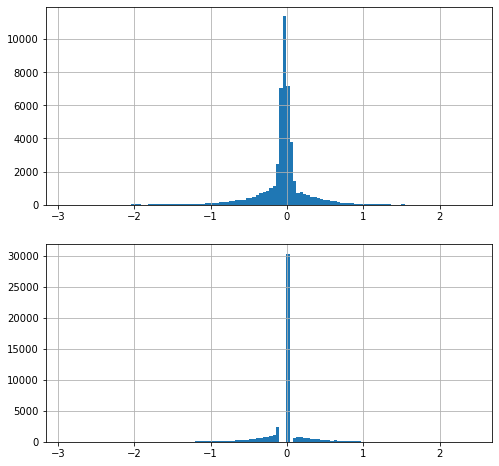

In [15]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
ax[0].hist(fc1_SAVE.data.numpy().flatten(),len(fc1_SAVE))
ax[0].grid(True)
ax[1].hist(clipped.data.numpy().flatten(),len(clipped))
ax[1].grid(True)
plt.show();

- **Subtask 3: Run inference for different levels of sparsity by varying  𝛼 , and plot a graph of sparsity vs. test accuracy.**

alpha = 0.05, acc = 0.88
alpha = 0.1, acc = 0.88
alpha = 0.15, acc = 0.87
alpha = 0.2, acc = 0.87
alpha = 0.25, acc = 0.84
alpha = 0.3, acc = 0.72


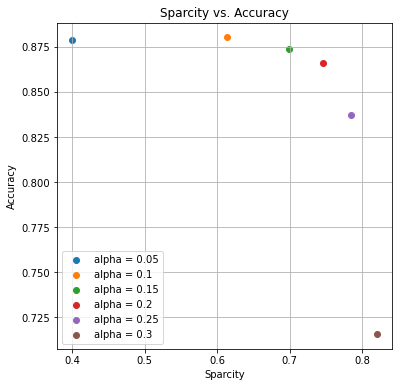

In [16]:
#TODO: 
fig, ax = plt.subplots(1,figsize=(6,6))

# Define Ranks
r1_arr = [10,20,30,40,50]
r2_arr = [10,20,30,40,50]

# Define alphas
alphas = np.linspace(0.05, 0.3, 6)

for i, alpha in enumerate(alphas):
    num_labels = 0
    num_correct = 0
    num_sparcity = 0
    total_elements = 0
    acc = 0
    sparcity = 0

    # Assign new weights
    model.conv1.weight.data = weight_clipping(model.conv1.weight.data, alpha)
    model.conv2.weight.data = weight_clipping(model.conv2.weight.data, alpha)
    model.fc1.weight.data = weight_clipping(model.fc1.weight.data, alpha)
    model.fc2.weight.data = weight_clipping(model.fc2.weight.data, alpha)
    model.fc3.weight.data = weight_clipping(model.fc3.weight.data, alpha)

    for X, y in train:
        # Calculate Accuracy
        outputs = model(X)
        outputs = outputs.detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        y = y.detach().numpy()
        num_correct += np.sum(outputs == y)
        num_labels += y.shape[0]

    # Calculate Sparcity %
    num_sparcity += len((model.conv1.weight.data == 0).nonzero())
    num_sparcity += len((model.conv2.weight.data == 0).nonzero())
    num_sparcity += len((model.fc1.weight.data == 0).nonzero())
    num_sparcity += len((model.fc2.weight.data == 0).nonzero())
    num_sparcity += len((model.fc3.weight.data == 0).nonzero())
    total_elements += torch.numel(model.conv1.weight.data)
    total_elements += torch.numel(model.conv2.weight.data)
    total_elements += torch.numel(model.fc1.weight.data)
    total_elements += torch.numel(model.fc2.weight.data)
    total_elements += torch.numel(model.fc3.weight.data)
        
    # Plot
    acc = num_correct / num_labels
    sparcity = num_sparcity / total_elements
    print(f'alpha = {round(alpha,3)}, acc = {round(acc,2)}')
    ax.scatter(sparcity, acc, label=f'alpha = {round(alpha,3)}')

ax.set_title('Sparcity vs. Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Sparcity')
ax.grid(True)
ax.legend()
plt.show();

# 3. Improved RNN (35 points)

- **Subtask 3: Run inference for different levels of sparsity by varying $\alpha$, and plot a graph of sparsity vs. test accuracy.** 

In this section we will implement a different type of RNN, one with weighted residual connections, and try to analyze it's usefulness. 

Let $X = [x 1 , . . . , x^T ]$ be the input data where $x_t \in R^D$ denotes the t-th step feature vector. Then,
the goal of multi-class RNNs is to learn a function F : R D×T → {1, . . . , L} that predicts one of L
classes for the given data point X. Standard RNN architecture has a provision to produce an output
at every time step, but we focus on the setting where each data point is associated with a single label
that is predicted at the end of the time horizon T . Standard RNN maintains a vector of hidden state
$h_t ∈ R^D̂$ which captures temporal dynamics in the input data, i.e., $$h_t = f(W \, x_t + U \, h_{t-1} + b)$$

Learning U, W in the above architecture is difficult as the gradient
can have exponentially large (in T) condition number, which leads to problems like exploding or vanishing gradients. Instead, ImprovedRNN will use a simple weighted residual connection to perform updates of the hidden state $h_t$ as follows: $$ h̃_t = f(Wx_t + Uh_{t−1} + b)$$  $$h_t = \alpha h̃_t + βh_{t−1} $$

where 0 ≤ α, β ≤ 1 are trainable scalar weights.


- **(20 points) Subtask 1: Implement the `ImprovedRNNCell` by extending the RNNCell defined in `eep590_utils.py`, which extends `nn.Module` in pytorch.** 

In [17]:
#TODO: DONE

class ImprovedRNNCell(RNNCell):
    '''
    ImprovedRNN Cell with both Full Rank and Low Rank Formulations
    Has multiple activation functions for the gates
    hidden_size = # hidden units
    update_nonlinearity = nonlinearity for final rnn update
    can be chosen from [tanh, sigmoid, relu, quantTanh, quantSigm]
    wRank = rank of W matrix (creates two matrices if not None)
    uRank = rank of U matrix (creates two matrices if not None)
    wSparsity = intended sparsity of W matrix(ces)
    uSparsity = intended sparsity of U matrix(ces)
    The cell will not automatically sparsify. The user must invoke .sparsify() to hard threshold.
    alphaInit = init for alpha, the update scalar
    betaInit = init for beta, the weight for previous state
    Basic architecture is like:
    h_t^ = update_nl(Wx_t + Uh_{t-1} + B_h)
    h_t = sigmoid(beta)*h_{t-1} + sigmoid(alpha)*h_t^
    W and U can further parameterised into low rank version by
    W = matmul(W_1, W_2) and U = matmul(U_1, U_2)
    '''

    def __init__(self, input_size, hidden_size,
                 update_nonlinearity="tanh", wRank=None, uRank=None,
                 wSparsity=1.0, uSparsity=1.0, alphaInit=-3.0, betaInit=3.0,
                 name="ImprovedRNN"):
        super(ImprovedRNNCell, self).__init__(input_size, hidden_size,
                                           None, update_nonlinearity,
                                           1, 1, 1, wRank, uRank, wSparsity,
                                           uSparsity)
        # TODO: DONE
        # Initialize all the required variables
        # https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html
        self.alphaInit = alphaInit
        self.betaInit = betaInit
        self.W = torch.empty(0)
        self.W1 = torch.empty(0)
        self.W2 = torch.empty(0)
        self.U = torch.empty(0)
        self.U1 = torch.empty(0)
        self.U2 = torch.empty(0)
        self.alpha = alphaInit * torch.ones([1, 1])
        self.beta = betaInit * torch.ones([1, 1])
        self.B = torch.ones([1, hidden_size])
        
        if wRank is not None:
            self.W1 = torch.randn([input_size, wRank])
            self.W2 = torch.randn([wRank, hidden_size])
        else:
            self.W = torch.randn([input_size, hidden_size])
            
        if uRank is not None:
            self.U1 = torch.randn([hidden_size, uRank])
            self.U2 = torch.randn([uRank, hidden_size])
        else:
            self.U = torch.randn([hidden_size, hidden_size])
        
    @property
    def name(self):
        return self._name

    @property
    def cellType(self):
        return "ImprovedRNN"

    def forward(self, input, state):
        # TODO: DONE
        # Implement the forward pass to compute the new_state
        B_h = self.B
        h_t_1 = state
        
        Wx_t = torch.empty(0)
        if self.wRank() is not None:
            Wx_t = torch.matmul( torch.matmul(input,self.W1), self.W2 )
        else:
            Wx_t = torch.matmul( input, self.W )
            
        Uh_t_1 = torch.empty(0)
        if self.uRank() is not None:
            Uh_t_1 = torch.matmul( torch.matmul(state,self.U1), self.U2 )
        else: 
            Uh_t_1 = torch.malmul( state, self.U )
            
        # h_t^ = update_nl(Wx_t + Uh_{t-1} + B_h)
        h_t_hat = gen_nonlinearity( Wx_t + Uh_t_1 + B_h, self.update_nonlinearity())
        
        # h_t = sigmoid(beta)*h_{t-1} + sigmoid(alpha)*h_t^
        h_t = torch.sigmoid(self.beta)*h_t_1 + torch.sigmoid(self.alpha)*h_t_hat
        
        new_state = h_t
        
        return new_state

In [22]:
model2 = ImprovedRNNCell(20,20)

- **(10 points) Subtask 2: Explain how Improved RNN resolves some of the problems in traditional RNNs from an optimization perspective.** Assume that the label decision function is one dimensional and is given by $f (X) = v^⊤ h_T$ . Let $L(X, y; θ) = L(f (X), y; θ)$ be the logistic loss function for the given labeled data point $(X, y)$ and with parameters $θ = (W, U, v)$. Then, check the gradients $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial U}$. A critical term in the expression of the gradients that determines whether it explodes/vanishes will be: $$M(U) = \prod_{k=t}^{T-1} (αU^T D_{k+1} + βI)$$ where $D_k = diag(σ′ (Wx_k + Uh_{k−1} + b))$ is the Jacobian matrix of the pointwise nonlinearity. **Hint: Analyze the range of possible values for the condition number $\kappa$ of the matrix $M(U)$**. 


#TODO: DONE

In normal RNN, the possible range for the condition number is a function of the exponential of T. Thus the gradient can explode or vanish in normal RNN. However, Improved RNN bounds the gradient expression to a small term such that it is much easier to converge.

- **(5 points) Subtask 3: Explain why this result is useful in the context of embedded real-time applications. Comment on representation power, memory-usage, and computation.** 

#TODO: DONE

The training process of a RNN with weighted residual connections converges much more easily even with large number of layers. The number of weights that are needed to be stored are much smaller , therefore the number of computations and power is much less. 

# 4. References & Misc. (15 points) 

**(a.) How many hours (approx) did you spend on this assignment totally? Document and explain your journey, including the issues/challenges you faced (both technical and non-technical).**

#TODO: DONE

This was another challenging assignment. I spent 3 days, 12 hours each day to complete this. I'm slowly gaining confidence in building these models, however it would be very helpful to see more examples. Also, I really value blogs that show the math, then a diagram, and then pseudo code. 

**(b.) Cite all the resources and references you consulted to complete this assignment.** 

#TODO: DONE

https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

https://drive.google.com/file/d/16DdwF4KIGi47ky7Q_B-4aApvMYW2evJZ/view

https://openreview.net/attachment?id=BJlaG0VFDH&name=original_pdf

https://web.stanford.edu/class/cs168/l/l9.pdf

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

https://www.geeksforgeeks.org/image-reconstruction-using-singular-value-decomposition-svd-in-python/

https://jramapuram.github.io/ramblings/rnn-backrpop/

https://cs224d.stanford.edu/lecture_notes/notes4.pdf